# PyTorch Linear Regression

### This implementation uses PyTorch to build a linear regression model

### Goal: Predict used car prices and compare with No-Framework and Scikit-Learn

What PyTorch provides (That we built manually in No-Framework)
- `torch.Tensor`: GPU-compatible arrays that track gradients automatically
- `torch.nn.Linear`: Encapsulates weights and bias in a single layer
- `torch.nn.MSELoss`: Pre-built loss function (replaces our manual compute_cost)
- `torch.optim.SGD`: Optimizer that handles parameter updates (replaces manual gradient descent)
- `auotgrad`: Automatic differentiation - computes gradients via .backward()

Key Concept - Autograd:
- In No-Framework, we manually computed gradients
- In PyTorch, we jull call loss.backward() and gradients are computed automatically
- This is the foundation of modern deep learning - same math, zero manual calculus

In [1]:
# torch: The main PyTorch library for tensor operations and neural networks
import torch

# torch.nn: Neural network module containing layers, loss function, etc.
# We import it as 'nn' for shorter syntax
import torch.nn as nn

# torch.optim: Optimization algorithms (SGD, Adam, etc.)
# These handle the weights updates we did manually in No-Framework
import torch.optim as optim

# numpy: Still needed for initial data handling before converting to tensors
import numpy as np

#pandas: For loading CSV data
import pandas as pd

# matplotlib: for visualizations
import matplotlib.pyplot as plt

# os: File path handling
import os
# Sklearn utilities: Using these for consistency with  Scikit-Learn implementation
# This ensures identical train/test splits and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Performance tracking
import time
import tracemalloc
import platform

# Set random seeds for reporducibility
# We set seeds for BOTH numpy and torch to ensure consistent results
RANDOM_SEED = 113
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Random seed set to : {RANDOM_SEED}")

All imports successful!
PyTorch version: 2.10.0+cpu
Random seed set to : 113


# Load Cleaned Data

- Load the same pre-processed dataset used in NF and SL
- Using pandas for consistency with SL implementation
- This ensures fair comparison across all frameworks

In [2]:
# Define path to our cleaned dataset
DATA_PATH = os.path.join('..', '..', 'data', 'processed', 'vehicles_clean.csv')

# Load data using pandas
df = pd.read_csv(DATA_PATH)

# Verify data loaded correctly
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))

Dataset shape: (100000, 12)
Columns: ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']

First 3 rows:
   price    year  manufacturer  condition  cylinders  fuel  odometer  \
0  29990  2014.0             7          2          6     2   26129.0   
1   6995  2006.0            12          0          6     2  198947.0   
2   4995  2009.0            35          6          8     2  152794.0   

   title_status  transmission  drive  type  state  
0             0             2      0     8     17  
1             6             0      3    10      5  
2             0             0      3    11     22  


# Separate Features and Target

- Price is our TARGET variable 
- All other columns are FEATURES
- Same seperation as Scikit-Learn implementation

In [3]:
# Define target and column variable (same as scikit-learn)
TARGET_COLUMN = 'price'
FEATURE_COLUMNS = [ 'year', 'manufacturer', 'condition', 'cylinders',
                    'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']

# Extract target (y) and features (X) as numpy arrays
y = df[TARGET_COLUMN].values
X = df[FEATURE_COLUMNS].values

# Store feature names for later use (displaying learned weights)
FEATURE_NAMES = FEATURE_COLUMNS

# Verify shapes 
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nFeature Names: {FEATURE_NAMES}")

Features (X) shape: (100000, 11)
Target (y) shape: (100000,)

Feature Names: ['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']


# Train/Test Split

- Using Sklearn's train_test_split for consistency with Scikit-learn implementation
- Same 80/20 split, same random seed (113)
- This ensures we're comparing apples-to-applies across frameworks

In [4]:
# Split data using sklearn (same as Scikit-Learn)
X_train, X_test, y_train, y_test = train_test_split(
    X,                          # Features to split
    y,                          # Target to split
    test_size=0.2,              # 20% for testing, 80% for training
    random_state=RANDOM_SEED    # Seed 113 for reporoducibility
)

# Verify split sizes
print(f"Training set size: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set size: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Training set size: 80,000 samples (80%)
Test set size: 20,000 samples (20%)

X_train shape: (80000, 11)
X_test shape: (20000, 11)
y_train shape: (80000,)
y_test shape: (20000,)


# Feature Scaling (Z-Score Normalization)

- Using sklearn's StandardScaler for consistency with Scikit-Learn implementation
- Same z-score noramlization
- Fit on training data only, transform both train and test

In [5]:
# Create and fit scaler on training data (same as Scikit-Learn)
scaler = StandardScaler()

# fit_transform on training data: calculates mean/std AND applies scaling
X_train_scaled = scaler.fit_transform(X_train)

# transform on test data: uses mean/std from training (no data leakage)
X_test_scaled = scaler.transform(X_test)

# Display the learned scaling parameters
print("Scaling parameters (computed from training data):\n")
print(f"{'Feature':<15} {'Mean':>15} {'Std':>15}")
print("-" * 47)
for i, name in enumerate(FEATURE_NAMES):
    print(f"{name:<15} {scaler.mean_[i]:>15.2f} {scaler.scale_[i]:>15.2f}")

# Verify scaling worked - training data should have mean=0 and std=1
print("\n--- Verification (Training Data After Scaling) ---")
print(f"Mean of each feature (should be 0): {np.mean(X_train_scaled, axis=0).round(6)}")
print(f"Std of each feature (should be 1): {np.std(X_train_scaled, axis=0).round(6)}")

Scaling parameters (computed from training data):

Feature                    Mean             Std
-----------------------------------------------
year                    2012.32            5.79
manufacturer              18.24           11.48
condition                  3.09            2.43
cylinders                  6.00            1.92
fuel                       2.05            0.78
odometer               94235.84        62977.76
title_status               0.23            1.06
transmission               0.39            0.77
drive                      1.40            1.21
type                       7.14            4.12
state                     23.60           15.10

--- Verification (Training Data After Scaling) ---
Mean of each feature (should be 0): [ 0.  0.  0. -0.  0. -0. -0.  0.  0. -0. -0.]
Std of each feature (should be 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Convert to PyTorch Tensors

**NEW PYTORCH CONCEPT: Tensors**

Tensors are PyTorch's fundamental data structure (like NumPy arrays but with superpowers):
- Can run on GPU for massive speedups
- Track operations for automatic gradient computation (autograd)
- Required format for all PyTorch models

Key considerations:
- Pytorch expects `float32` dtype (not float64 which NumPy uses by default)
- Target (y) must be reshaped from (n,) to (n, 1) for PyTorch's loss functions

In [6]:
# Convert NumPy arrays to PyTorch tensors

# torch.tensor() creates a tensor from data
# dtype=torch.float32 is REQUIRED because:
# 1. PyTorch defaults to float32 for efficiency (uses less memory than float64)
# 2. Neural network layers expect flaot32 inputs
# 3. GPU operations are optimized for float32

# Convert features (X) to tensors
# Shapes stay the same (80000, 11) and (20000, 11)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convert target (y) to tensors
# IMPORTANT: Reshape (n,) to (n, 1) using .reshape(-1, 1)
# -1 means "infer this dimension" (PyTorch figures out it's 80000)
# 1 means "one column"
# This reshaping is needed because:
# - nn.Linear outputs shape (n, 1)
# - Loss function needs y_pred and y_true to have same shape
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Verify tensor shapes and types
print("Tensor shapes:")
print(f"    X_train_tensor: {X_train_tensor.shape}")
print(f"    X_test_tensor:  {X_test_tensor.shape}")
print(f"    y_train_tensor: {y_train_tensor.shape}")
print(f"    y_test_tensor:  {y_test_tensor.shape}")

print(f"\nTensor dtypes:")
print(f"    x_train_tensor: {X_train_tensor.dtype}")
print(f"    y_train_tensor: {y_train_tensor.dtype}")

# Show that tensors are on CPU (we're not using GPU for this project)
print(f"\nDevice: {X_train_tensor.device}")

Tensor shapes:
    X_train_tensor: torch.Size([80000, 11])
    X_test_tensor:  torch.Size([20000, 11])
    y_train_tensor: torch.Size([80000, 1])
    y_test_tensor:  torch.Size([20000, 1])

Tensor dtypes:
    x_train_tensor: torch.float32
    y_train_tensor: torch.float32

Device: cpu


# Define the Model

PyTorch uses `nn.Module` as the base class for all neural networks. For linear regression, we use `nn.Linear` which encapsulates:
- **Weights**: Automatically initialized (no manual `np.zeros()` needed)
- **Bias**: Included by default
- **Forward pass**: Built-in matrix multiplication

| PyTorch | No-Framework Equivalent |
|---------|------------------------|
| `nn.Linear(11, 1)` | `weights = np.zeros(11)` + `bias = 0` |
| `model(X)` | `X @ weights + bias` |
| `model.parameters()` | Manual weight/bias variables |


In [7]:
# DEFINE THE MODEL

# nn.Linear creates a fully connected layer:
# - First argument (11): number of input features
# - Second argument (1): number of outputs (1 for regression)
# - Automatically intializes weights and bias internally

# Define a simple linear regression model using nn.Linear
# This replaces our manual weights = np.zeros() and bias = 0 from No-Framework
model = nn.Linear(in_features=11, out_features=1)

# Inspect the model architecture
print("Model Architecture")
print(model)
print()

# View the learnable parameters (weights and bias)
# model.parameters() returns as iterator over all trainable parameters
print("Learnable Parameters:")
for name, param in model.named_parameters():
    # name: 'weight' or 'bias'
    # param: the actual tensor containing values
    print(f"    {name}: shape {param.shape}")
print()

# Show initial weight values (randomly initialized, not zeros like No-Framework)
print("Initial Weight Values (first 5):")
print(f"    {model.weight.data[0, :5]}")
print(f"\nInitial Bias Value:")
print(f"    {model.bias.data}")

Model Architecture
Linear(in_features=11, out_features=1, bias=True)

Learnable Parameters:
    weight: shape torch.Size([1, 11])
    bias: shape torch.Size([1])

Initial Weight Values (first 5):
    tensor([-0.2362,  0.0226,  0.2529,  0.1047, -0.2397])

Initial Bias Value:
    tensor([-0.0643])


# Loss Function and Optimizer

PyTorch separates the "what to minimize" (loss function) from "how to minimize it" (optimizer):

- **Loss Function (`nn.MSELoss`)**: Calculates Mean Squared Error, same as our No-Framework cost function
- **Optimizer (`optim.SGD`)**: Performs gradient descent, replacing our manual weight update loop

| PyTorch | No-Framework Equivalent |
|---------|------------------------|
| `nn.MSELoss()` | `cost = (1/m) * np.sum((predictions - y)**2)` |
| `optim.SGD(params, lr)` | `weights -= learning_rate * gradient` |
| `optimizer.step()` | Manual weight/bias updates |


In [8]:
# LOSS FUNCTION AND OPTIMIZER

# Define the loss function (what we want to minimize)
# nn.MSELoss computes Mean Squared Error
# This is identical to the No-Framework cost function
criterion = nn.MSELoss()

# Define the optimizer (how we minimize the loss)
# SGD = Stochastic Gradient Descent (same algorithm as No-Framework)
# Parameters:
# - model.parameters(): tells optimizer which values to update
# - lr: learning rate (same 0.01 used in No-Framework)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Display configuration
print("Loss Function:", criterion)
print(f"Optimizer: SGD with learning_rate= {learning_rate}")
print(f"\nNo-Framework Comparison:")
print(f"    Our manual gradient descent used the same lr={learning_rate}")
print(f"    PyTorch automates the weight updates I coded manually")

Loss Function: MSELoss()
Optimizer: SGD with learning_rate= 0.01

No-Framework Comparison:
    Our manual gradient descent used the same lr=0.01
    PyTorch automates the weight updates I coded manually


# Training Loop

The PyTorch training loop follows a consistent pattern for every model:

1. **Forward pass**: `predictions = model(X)` - compute outputs
2. **Compute loss**: `loss = criterion(predictions, y)` - measure error
3. **Zero gradients**: `optimizer.zero_grad()` - clear old gradients
4. **Backward pass**: `loss.backward()` - compute new gradients (autograd!)
5. **Update weights**: `optimizer.step()` - apply gradient descent

| PyTorch | No-Framework Equivalent |
|---------|------------------------|
| `model(X_train)` | `X @ weights + bias` |
| `loss.backward()` | `compute_gradients()` (manual math) |
| `optimizer.step()` | `weights -= lr * dW; bias -= lr * dB` |


In [9]:
# TRAINING LOOP

# Hyperparameters (same as NF for fair comparison)
num_iterations = 1000
print_every = 100

# Store loss history for plotting
loss_history = []

print("Training Linear Regression Model...")
print("=" * 50)

# Training loop - iterates num_iterations time
for iteration in range(num_iterations):
    # Step 1: Forward pass
    # Pass training data through the model to get predictions
    predictions = model(X_train_tensor)

    # Step 2: Compute loss
    # Calculate MSE between predictions and actual values
    loss = criterion(predictions, y_train_tensor)

    # Step 3: Zero Gradients
    # Clear gradients from previous iteration
    optimizer.zero_grad()

    # Step 4: Backward Pass (AUTOGRAD)
    # Automatically compute gradients of loss w.r.t. all parameters
    # This replaces my entire compute_gradients() function
    loss.backward()

    # Step 5: Update weights - Apply gradient descent
    optimizer.step()

    # Store loss for plotting (convert tensor to Python float)
    loss_history.append(loss.item())

    # Print progress every print_every iterations
    if (iteration + 1) % print_every == 0:
        print(f"    Iteration {iteration + 1:4d}/{num_iterations} | Loss: {loss.item():.4f}")

print("=" * 50)
print(f"Training Complete!")
print(f"    Initial Loss:   {loss_history[0]:.4f}")
print(f"    Final Loss:     {loss_history[-1]:.4f}")

Training Linear Regression Model...
    Iteration  100/1000 | Loss: 109227488.0000
    Iteration  200/1000 | Loss: 101801136.0000
    Iteration  300/1000 | Loss: 101656936.0000
    Iteration  400/1000 | Loss: 101653168.0000
    Iteration  500/1000 | Loss: 101652968.0000
    Iteration  600/1000 | Loss: 101652944.0000
    Iteration  700/1000 | Loss: 101652944.0000
    Iteration  800/1000 | Loss: 101652944.0000
    Iteration  900/1000 | Loss: 101652952.0000
    Iteration 1000/1000 | Loss: 101652944.0000
Training Complete!
    Initial Loss:   569607296.0000
    Final Loss:     101652944.0000


# Evaluation

To evaluate the model, we use `torch.no_grad()` context manager which:
- **Disables gradient tracking** - saves memory and computation
- **Used for inference only** - we're not training, just predicting

We then convert PyTorch tensors back to NumPy arrays to calculate our standard metrics (MSE, RMSE, R²) for comparison with No-Framework and Scikit-Learn.


In [11]:
# EVALUATION

# torch.no_grad() disables graident computation for inference
# This saves memory and speeds up predictions 
with torch.no_grad():
    # Make predictions on test set
    y_pred_tensor = model(X_test_tensor)

# Conver predictions from PyTorch tensor to NumPy array
y_pred = y_pred_tensor.numpy().flatten()

# Calculate evaluation metrics
mse = np.mean((y_pred - y_test) ** 2)

# RMSE:
rmse = np.sqrt(mse)

# R^2:
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Display results
print("=" * 50)
print("MODEL EVALUATION (Test Set)")
print("=" * 50)
print(f"    Mean Squared Error:     {mse:,.2f}")
print(f"    Root Mean Squared Error:    ${rmse:,.2f}")
print(f"    R^2 Score:  {r2:.4f}")
print()
print("Comparison with previous Implementation")
print("-" * 50)
print(f"  {'Metric':<12} {'No-Framework':>14} {'Scikit-Learn':>14} {'PyTorch':>14}")
print(f"  {'-'*12} {'-'*14} {'-'*14} {'-'*14}")
print(f"  {'RMSE':<12} {'$10,058':>14} {'$10,105':>14} {f'${rmse:,.0f}':>14}")
print(f"  {'R²':<12} {'0.4983':>14} {'0.4986':>14} {f'{r2:.4f}':>14}")

MODEL EVALUATION (Test Set)
    Mean Squared Error:     102,115,049.70
    Root Mean Squared Error:    $10,105.20
    R^2 Score:  0.4986

Comparison with previous Implementation
--------------------------------------------------
  Metric         No-Framework   Scikit-Learn        PyTorch
  ------------ -------------- -------------- --------------
  RMSE                $10,058        $10,105        $10,105
  R²                   0.4983         0.4986         0.4986


# Visualizations

We'll create the same three visualizations as No-Framework and Scikit-Learn
1. Cost Curve
2. Predictions vs Actual
3. Feature Importance

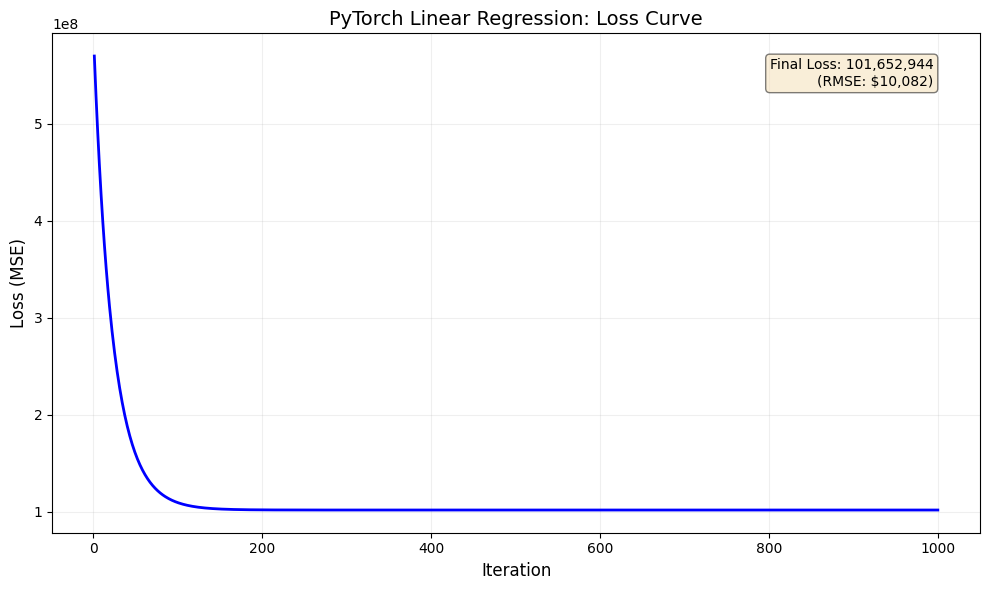

Saved: results/baseline/cost_curve.png


In [12]:
# VISUALIZATION 1: Cost Curve

# Create results directory
results_dir = "results/baseline"
os.makedirs(results_dir, exist_ok=True)

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), loss_history, color='blue', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('PyTorch Linear Regression: Loss Curve', fontsize=14)
plt.grid(True, alpha=0.2)

# Add annotation showing convergence
plt.annotate(
    f'Final Loss: {loss_history[-1]:,.0f}\n(RMSE: ${np.sqrt(loss_history[-1]):,.0f})',
    xy=(0.95, 0.95),
    xycoords='axes fraction',
    fontsize=10,
    ha='right',
    va='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.savefig(f'{results_dir}/cost_curve.png', dpi=150)
plt.show()
print(f"Saved: {results_dir}/cost_curve.png")

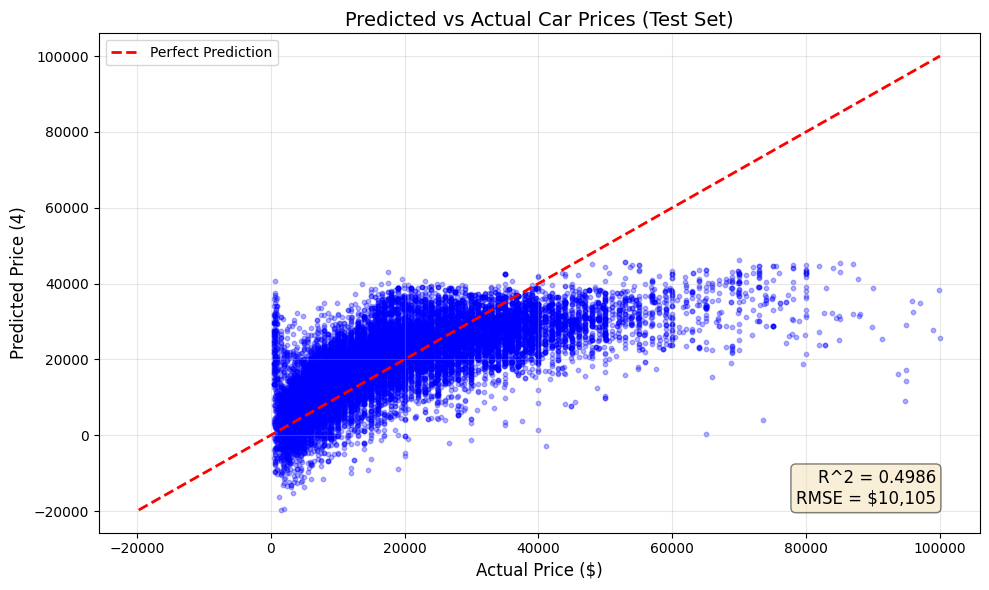

Saved results/baseline/predictions_vs_actual.png


In [14]:
# VISUALIZATION 2: Predictions vs Actual
plt.figure(figsize=(10, 6))

# Scatter plot of predicted vs actual values
plt.scatter(y_test, y_pred, alpha=0.3, color='blue', s=10)

# Perfect predicted line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price (4)', fontsize=12)
plt.title('Predicted vs Actual Car Prices (Test Set)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Add R^2 and RMSE annotation in bottom-right corner
plt.annotate(f'R^2 = {r2:.4f}\nRMSE = ${rmse:,.0f}',
             xy=(0.95, 0.05), xycoords='axes fraction',
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{results_dir}/predictions_vs_actual.png', dpi=150)
plt.show()
print(f"Saved {results_dir}/predictions_vs_actual.png")

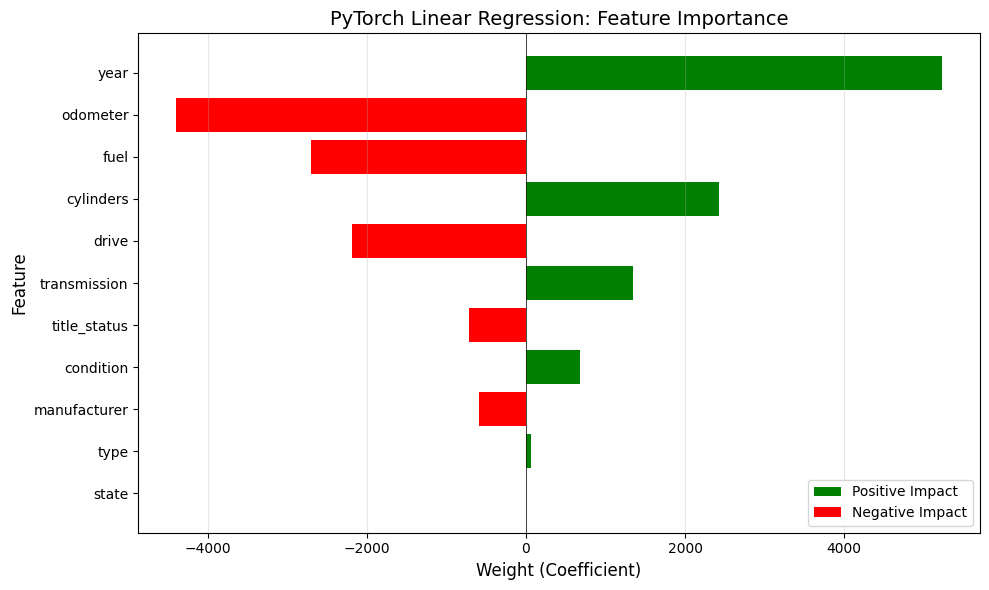

Saved: results/baseline/feature_importance.png


In [16]:
# VISUALIZATION 3: Feature Importance

# Extract weights from the PyTorch model
weights = model.weight.data.numpy().flatten()

# Get feature names (same order as training data)
feature_names = [col for col in df.columns if col != 'price']

# Create dataframe for easier plotting
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
}).sort_values('Abs_Weight', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
colors = ['green' if w > 0 else 'red' for w in feature_importance['Weight']]
plt.barh(feature_importance['Feature'], feature_importance['Weight'], color=colors)
plt.xlabel('Weight (Coefficient)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('PyTorch Linear Regression: Feature Importance', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Positive Impact'),
    Patch(facecolor='red', label='Negative Impact')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f'{results_dir}/feature_importance.png', dpi=150)
plt.show()
print(f"Saved: {results_dir}/feature_importance.png")
